In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('RSCCASN.csv',index_col='DATE',parse_dates=True)

In [3]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [4]:
df.columns = ['Sales']

In [5]:
df.head()

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


<Axes: xlabel='DATE'>

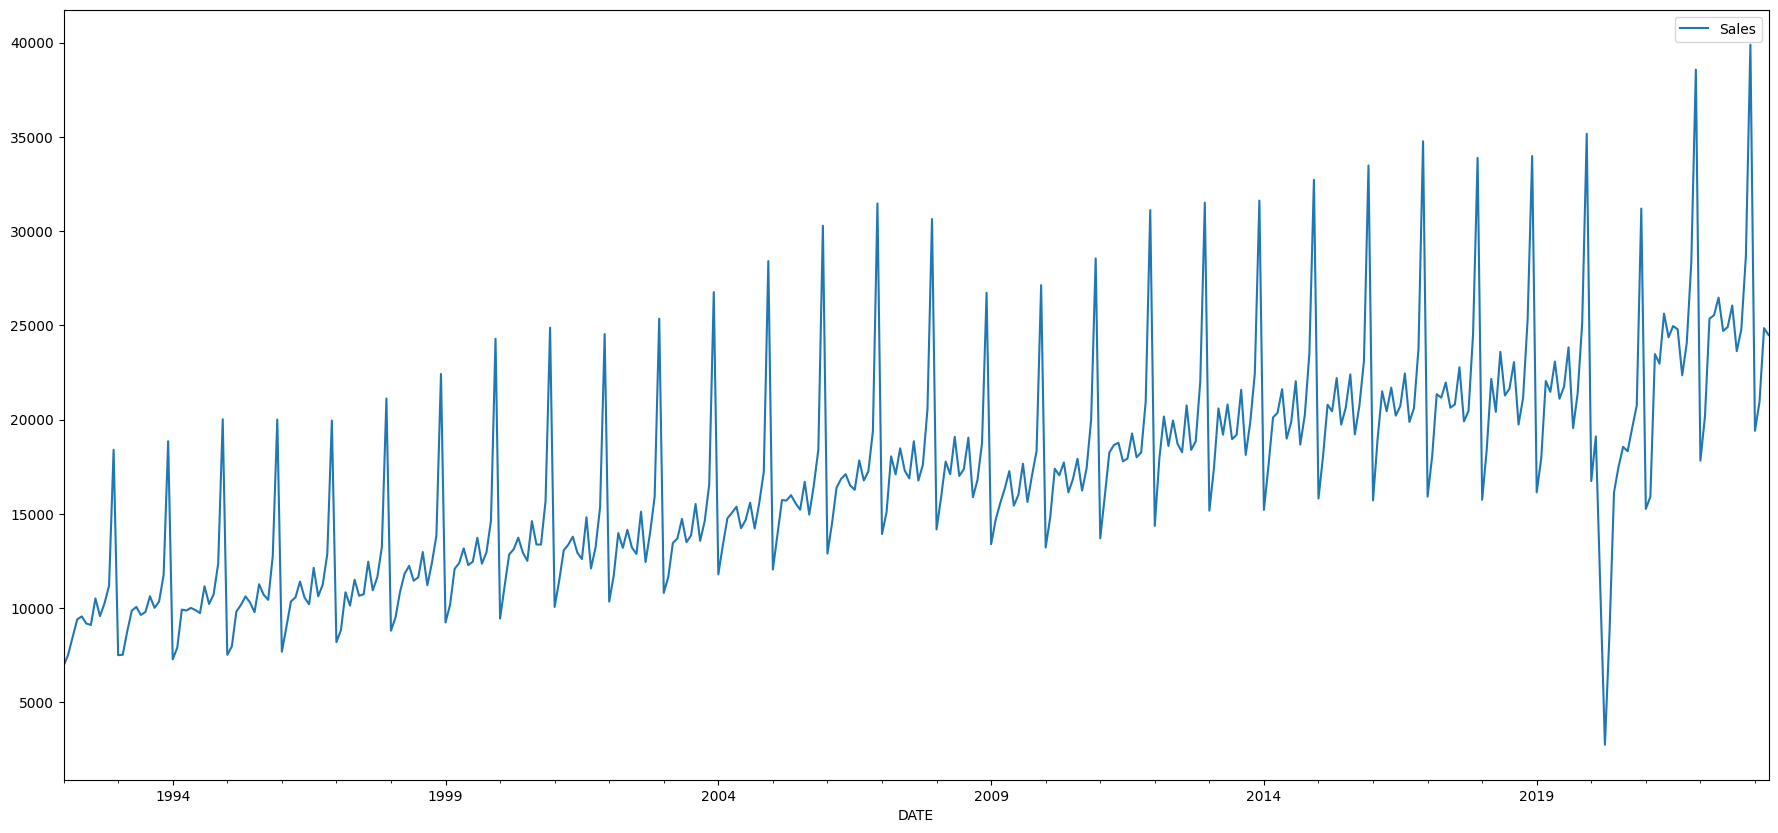

In [7]:
df.plot(figsize=(22,10))

## Répartition Entraînement / Test

> Indented block

In [8]:
len(df)

376

Les données sont mensuelles, prévoyons un an et demi dans le futur.

In [9]:
len(df)-18

358

In [10]:
test_size = 18

In [11]:
test_ind = len(df)-test_size

In [12]:
test_ind

358

In [13]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [14]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2021-06-01,24364
2021-07-01,24961
2021-08-01,24789


In [15]:
test

,Sales
DATE,
2021-11-01,28340
2021-12-01,38564
2022-01-01,17817
2022-02-01,20152
2022-03-01,25347
2022-04-01,25539
2022-05-01,26470
2022-06-01,24701
2022-07-01,24904


## Mise à l'échelle des données

In [16]:
from sklearn.preprocessing import MinMaxScaler

In [17]:
scaler = MinMaxScaler()

In [18]:
# Si warning, ignorez le, cest juste une conversion en float
# Adapter uniquement aux données d'entraînement, sinon nous trichons en supposant des informations sur les données test
scaler.fit(train)

MinMaxScaler()

In [19]:
scaler_train = scaler.transform(train)
scaler_test = scaler.transform(test)

## Générateur de séries temporelles

In [20]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [21]:
# Redéfinissons pour obtenir 12 mois en arrière et prédisons le mois suivant
length = 12
generator = TimeseriesGenerator(scaler_train, scaler_train, length=length, batch_size=1)

In [22]:
# À quoi ressemble le premier batch ?
X,y = generator[0]

In [23]:
print(f"Compte tenu du tableau suivant : \n {X.flatten()}")
print(f'Cela prédit ce y : \n {y}')

Compte tenu du tableau suivant : 
 [0.12916564 0.14724759 0.1765922  0.20516539 0.21000987 0.1984078
 0.19597013 0.23947791 0.21047272 0.23148605 0.26027524 0.48268946]
Cela prédit ce y : 
 [[0.14656875]]


## Création du Modèle

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [25]:
# Nous n'utilisons qu'une seule feature dans notre série temporelle
n_features = 1

In [26]:
# définir le modèle
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


## EarlyStopping et création d'un Générateur de Validation

REMARQUE : la taille de l'ensemble de données scaled_test DOIT être supérieure à la longueur choisie pour vos batchs. Regardez la vidéo pour plus d'informations à ce sujet.

In [28]:
from tensorflow.keras.callbacks import EarlyStopping

In [29]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [30]:
validation_generator = TimeseriesGenerator(scaler_test,scaler_test,length=length,batch_size=1)

In [31]:
model.fit_generator(generator,epochs=20, validation_data=validation_generator,callbacks=[early_stop])

Epoch 1/20


C:\Users\Administrator\AppData\Local\Temp\ipykernel_16300\1459820252.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=20, validation_data=validation_generator,callbacks=[early_stop])


346/346 [==============================] - 3s 5ms/step - loss: 0.0245 - val_loss: 0.0807
Epoch 2/20
346/346 [==============================] - 2s 5ms/step - loss: 0.0177 - val_loss: 0.0379
Epoch 3/20
346/346 [==============================] - 2s 5ms/step - loss: 0.0138 - val_loss: 0.0171
Epoch 4/20
346/346 [==============================] - 2s 7ms/step - loss: 0.0113 - val_loss: 0.0113
Epoch 5/20
346/346 [==============================] - 2s 5ms/step - loss: 0.0079 - val_loss: 0.0377
Epoch 6/20
346/346 [==============================] - 1s 4ms/step - loss: 0.0064 - val_loss: 0.0049
Epoch 7/20
346/346 [==============================] - 2s 6ms/step - loss: 0.0057 - val_loss: 0.0017
Epoch 8/20
346/346 [==============================] - 2s 7ms/step - loss: 0.0059 - val_loss: 2.9565e-04
Epoch 9/20
346/346 [==============================] - 2s 6ms/step - loss: 0.0050 - val_loss: 4.0364e-04
Epoch 10/20
346/346 [==============================] - 2s 6ms/step - loss: 0.0049 - val_loss: 0.0256


In [32]:
losses = pd.DataFrame(model.history.history)

<Axes: >

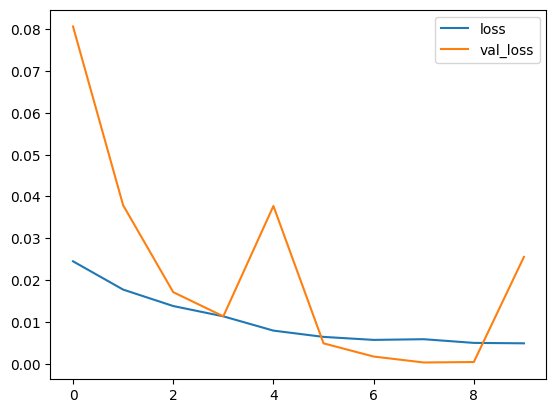

In [33]:
losses.plot()